###Импорт библиотек

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
import networkx as nx
import re
import time
import math as math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

###Загрузка и знакомство с датасетом

In [101]:
df=pd.read_csv("/content/all_ai_tool.csv")
df.head(100)

,AI Tool Name,Description,Free/Paid/Other,Useable For,Charges,Review,Tool Link,Major Category
0,Farm3D,Learning Articulated 3D Animals by Distilling ...,Free,/ experiments / 3D,NaN,NaN,https://farm3d.github.io/?utm_source=futureped...,other
1,Mailbutler Ai,"AI-powered Smart Assistant for Outlook, Gmail ...",Freemium,/ email assistant,$ 4.95/mo,1,https://www.mailbutler.io/smart-assistant/?utm...,text
2,Maverick,Send customers personalized videos at scale.,Paid,/ e-commerce / audio editing,$ 100/mo,NaN,https://www.trymaverick.com/?utm_source=future...,audio
3,0Xai,Stable Diffusion Prompt And Images Generator,Free,/ image generator / prompts,NaN,NaN,https://0xai.quest?utm_source=futurepedia&utm_...,image
4,10Web,AI-powered WordPress platform for automated we...,Freemium,/ low-code/no-code,NaN,NaN,https://10web.io/?utm_source=futurepedia&utm_m...,code
...,...,...,...,...,...,...,...,...
95,Ai Email Generator,AI Email Generator is an AI-powered tool desig...,Freemium,/ email assistant,$ 85/mo,NaN,https://leadiq.com/scribe-generative-ai-for-sa...,text
96,Ai Email Writer,Email generation assistance software.,Free,/ email assistant,NaN,NaN,https://ai-emailwriter.com/?utm_source=futurep...,text
97,Ai Engine,AI-powered plugin enhancing WordPress experien...,Freemium,/ low-code/no-code,$49,1,https://meowapps.com/ai-engine/?utm_source=fut...,code
98,Ai Essay Writer,Essay Writer AI Is Here to Save You Time,Freemium,/ general writing,$ 5/mo,NaN,https://essaywriters.ai/?utm_source=futurepedi...,text


In [102]:
df.shape

(4969, 8)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4969 entries, 0 to 4968
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   AI Tool Name     4969 non-null   object
 1   Description      4969 non-null   object
 2   Free/Paid/Other  4969 non-null   object
 3   Useable For      4969 non-null   object
 4   Charges          2534 non-null   object
 5   Review           1462 non-null   object
 6   Tool Link        4969 non-null   object
 7   Major Category   4969 non-null   object
dtypes: object(8)
memory usage: 310.7+ KB


In [104]:
df.describe()

,AI Tool Name,Description,Free/Paid/Other,Useable For,Charges,Review,Tool Link,Major Category
count,4969,4969,4969,4969,2534,1462,4969,4969
unique,4969,4965,19,526,557,17,4959,8
top,Farm3D,Understand any data instantly using AI,Free,/ productivity,$ 10/mo,1,https://www.trymaverick.com/?utm_source=future...,business
freq,1,2,1704,247,99,942,2,1202


###Построение распределений и изучение признаков

<Axes: title={'center': 'Распределение приложений по цене'}>

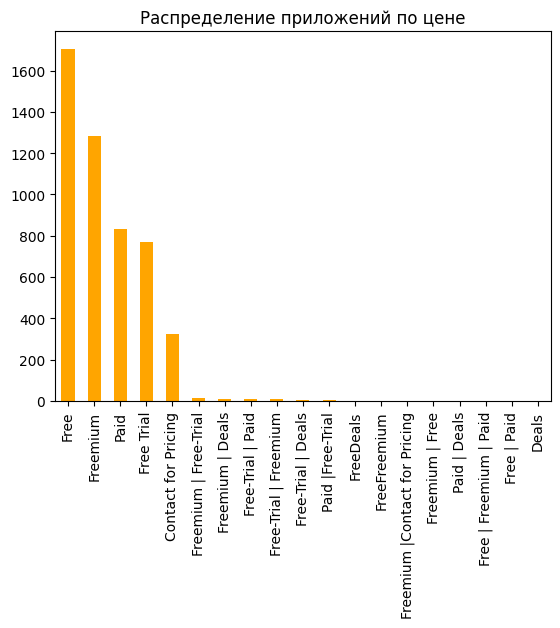

In [105]:
#Распределение цен
pricing_distribution = df["Free/Paid/Other"].value_counts()
pricing_distribution.plot(kind='bar', xlabel='', title='Распределение приложений по цене', color='orange')

Большая часть приложений в открытом доступе без надобности платить за пользование. Есть как полностью бесплатные приложения, так и с базовым бесплатным функционалом и платным расширенным. Данный признак, возможно, будем учитывать для построения рекомендательной системы

In [106]:
#Распределение категорий
category_distribution = df["Major Category"].value_counts()
category_distribution

Major Category
business    1202
text        1115
other        849
image        740
code         583
audio        330
video        110
3D            40
Name: count, dtype: int64

<Axes: title={'center': 'Распределение приложений по категориям'}>

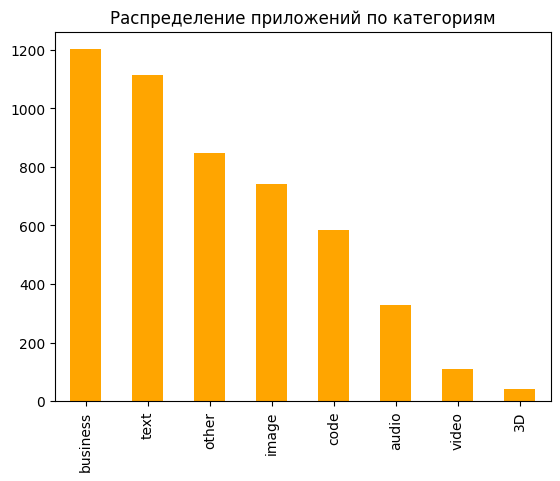

In [107]:
category_distribution.plot(kind='bar', xlabel='', title='Распределение приложений по категориям', color='orange')

По данному распределению можем сделать вывод о том, что все-таки большая часть имеющихся приложений отнесена к категориям бизнеса и работы с текстом. Для категорий с высокоми значениями нужно будет использовать и другие признаки, чтобы выделить рекомендации. Поскольку поиск только по категориям будет неэффективен.

In [108]:
reviews_overview = df["Review"].describe()
reviews_overview

count     1462
unique      17
top          1
freq       942
Name: Review, dtype: object

Отзывы есть лишь на 1/3 часть приложений из нашего списка. К сожалению, восполнить оценки нет возможности. Не будем учитывать данный признак в системе. Однако, если заполнить пропуски, этот признак будет крайне полезен при построении рекомендаций.

In [109]:
# Filtering tools with reviews greater than 1 and sorting them
top_tools_by_review = df[df["Review"] > "1"].sort_values(by="Review", ascending=False).head(10)

# Selecting relevant columns for display
top_tools_by_review = top_tools_by_review[["AI Tool Name", "Description", "Review", "Major Category", "Tool Link"]]

top_tools_by_review

,AI Tool Name,Description,Review,Major Category,Tool Link
1854,Gocharlie Ai,A generative AI platform for content creators!,undefined,text,https://gocharlie.ai/?utm_source=futurepedia&u...
4637,Vidyo.Ai,"Create short clips from long videos, save 90% ...",undefined,video,https://vidyo.ai/?utm_source=futurepedia&utm_m...
2666,Maverick,AI-generated personalized videos at scale,undefined,video,https://www.trymaverick.com/?utm_source=future...
4468,Ttsmaker,Free text-to-speech tool that offers over 100+...,9,audio,https://ttsmaker.com?utm_source=futurepedia&ut...
4204,Syllaby,Create Your Social Media Strategy In 10 Minutes,9,text,https://www.syllaby.io?utm_source=futurepedia&...
1907,Gptforslides,"Generate Beautiful Presentations with Images, ...",9,business,https://www.gptforslides.app/?utm_source=futur...
1326,Docus,"Providing personalized health insights, recomm...",9,other,https://docus.ai/?utm_source=futurepedia&utm_m...
4420,Traivl,Personalized multi-destination Travel Itinerary,9,other,https://www.traivl.com/?utm_source=futurepedia...
4256,Tammy Ai,YouTube summaries for free. 10x your learning ...,9,business,https://tammy.ai/?utm_source=futurepedia&utm_m...
656,Booke Ai,Streamline your bookkeeping business with AI-d...,9,business,https://booke.ai?utm_source=futurepedia&utm_me...


In [110]:
# Цены
charges_distribution = df["Charges"].value_counts().head(10)
charges_distribution

Charges
$ 10/mo      99
$ 9/mo       90
$ 19/mo      88
$ 29/mo      72
$ 5/mo       68
$ 9.99/mo    62
$ 15/mo      62
$ 20/mo      53
$5           46
$ 49/mo      45
Name: count, dtype: int64

<Axes: title={'center': 'Распределение платных приложений по размеру платы за месяц'}>

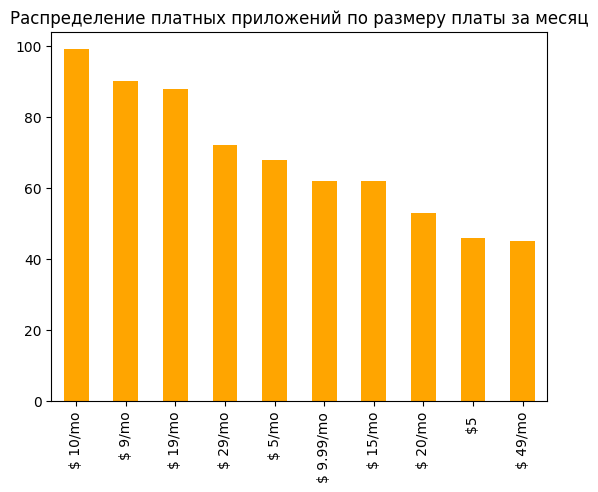

In [111]:
charges_distribution.plot(kind='bar', xlabel='', title='Распределение платных приложений по размеру платы за месяц', color='orange')

По списку наиболее часто встречающихся плат за пользование сервисами можно сделать вывод, что платных приложений не так много в сравнении с общим объемом, это было видно еще ранее, так же основной размер платы в месяц не превышает 50 долларов, что вполне приемлемо для данных сервисов

In [112]:
#распределение по областям, в которых приложение может быть применено

In [113]:
def get_formatted_uses(uses):
    formatted_uses = []
    for use in uses.split('/'):
        if use := use.strip():
            formatted_uses.append(use.capitalize())
    return formatted_uses


df['Useable For'] = df['Useable For'].map(get_formatted_uses)

In [114]:
uses_count = df['Useable For'].explode().value_counts()
labels = ['Редко используются', 'Используюся чуть чаще', 'Часто используются', 'Очень часто используются']
uses_distribution = pd.qcut(uses_count, q=4, labels=labels)

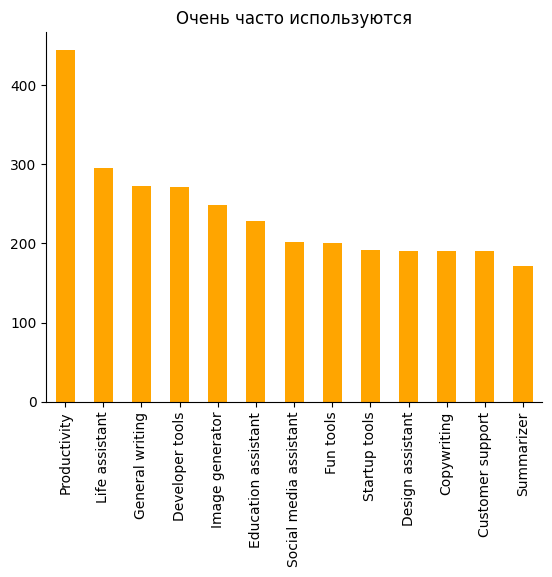

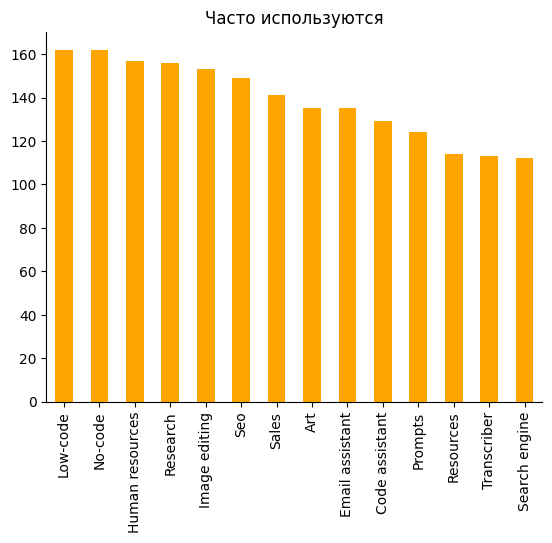

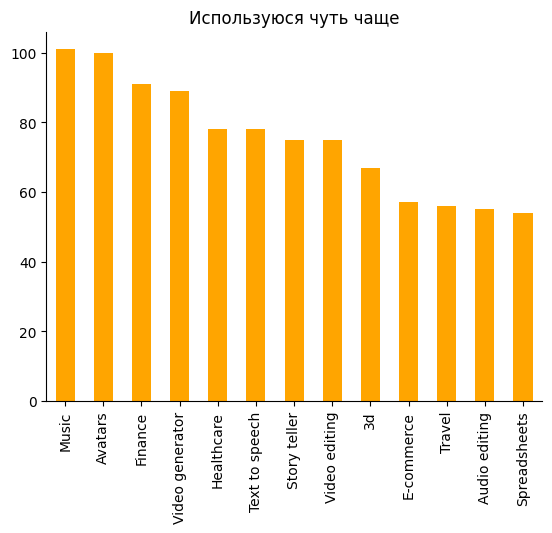

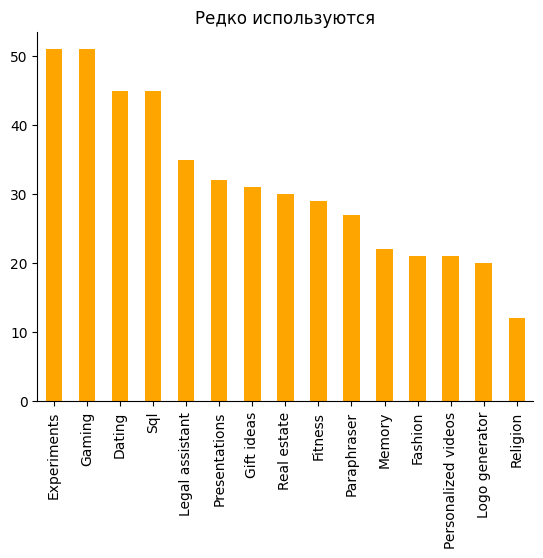

In [115]:
for label in reversed(labels):
    ax = uses_count[uses_distribution == label].plot(kind='bar', grid=False, title=f'{label}', xlabel='',color='orange')
    sns.despine()
    plt.show();

Топ 5 бесплатных приложений в каждой категории

In [116]:
free_tools = df[df["Free/Paid/Other"] == "Free"]
top_free_tools_by_category = free_tools.groupby("Major Category").head(5)
top_free_tools_by_category = top_free_tools_by_category[["AI Tool Name", "Description", "Major Category", "Tool Link"]]
top_free_tools_by_category

,AI Tool Name,Description,Major Category,Tool Link
0,Farm3D,Learning Articulated 3D Animals by Distilling ...,other,https://farm3d.github.io/?utm_source=futureped...
3,0Xai,Stable Diffusion Prompt And Images Generator,image,https://0xai.quest?utm_source=futurepedia&utm_...
5,1Pm Workout,Become The Next One Punch Man!,other,https://opmworkout.ml/?utm_source=futurepedia&...
6,2D&3D Video Converter,iDATAPP 3D Converter: Transform Your Videos in...,3D,https://idatapp.com/software/3d-converter?utm_...
9,3Dfy,3DFY.ai is an artificial intelligence (AI) too...,3D,https://3dfy.ai/?utm_source=futurepedia&utm_me...
11,6000 Thoughts,6000 Thoughts is an innovative AI-based app de...,other,https://6000thoughts.com/?utm_source=futureped...
13,6Pen,6Pen Art is an AI-powered product that generat...,image,https://6pen.art/?utm_source=futurepedia&utm_m...
20,Accio,AI-based tool that allows users to quickly an...,text,https://accio.springworks.in/?utm_source=futur...
22,Accountabilabuddy,Sends simple text reminders to help you stay o...,other,https://www.summit.im/accountabilabuddy?utm_so...
24,Acrostic Ai,Generate creative acrostic poems with AI for a...,other,https://acrostic.ai/?utm_source=futurepedia&ut...


##Построение рекомендательной системы

Для построения системы будем использовать признаки: Description, Major Category, Free/Paid/Other

Признак Description - текст, описание нашего инструмента. Из текста нужно будет выделить основные идеи и суть того, за что отвечает приложение и какой функционал имеет. Для этого проведем обработку текстовых данных и векторизацию текста

In [117]:
def remove(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [118]:
df['Preprocessed'] = df['Description'].apply(remove)
df['Preprocessed']

0       learning articulated d animals by distilling d...
1       aipowered smart assistant for outlook gmail an...
2             send customers personalized videos at scale
3            stable diffusion prompt and images generator
4       aipowered wordpress platform for automated web...
                              ...                        
4964    capture meaningful and actionable insights fro...
4965    zoomscape ai is an aipowered tool that enables...
4966    enables users to craft artistic qr codes by in...
4967             contract analysis and insight generation
4968    generation of promotional images without desig...
Name: Preprocessed, Length: 4969, dtype: object

In [119]:
start_time = time.time()
text_content = df['Preprocessed']
vector = TfidfVectorizer(max_df=0.4,
                             min_df=1,
                             stop_words='english',
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )
tfidf = vector.fit_transform(text_content)

k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]

request_transform = vector.transform(df['Preprocessed'])
df['cluster'] = kmeans.predict(request_transform)

df['cluster'].value_counts().head()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster
10     1975
114     169
45      117
111     113
36      104
Name: count, dtype: int64

In [120]:
#Разделим узлы на кластеры по векторному расстоянию между описаниями

In [121]:
df.head(10)

,AI Tool Name,Description,Free/Paid/Other,Useable For,Charges,Review,Tool Link,Major Category,Preprocessed,cluster
0,Farm3D,Learning Articulated 3D Animals by Distilling ...,Free,"[Experiments, 3d]",NaN,NaN,https://farm3d.github.io/?utm_source=futureped...,other,learning articulated d animals by distilling d...,32
1,Mailbutler Ai,"AI-powered Smart Assistant for Outlook, Gmail ...",Freemium,[Email assistant],$ 4.95/mo,1,https://www.mailbutler.io/smart-assistant/?utm...,text,aipowered smart assistant for outlook gmail an...,10
2,Maverick,Send customers personalized videos at scale.,Paid,"[E-commerce, Audio editing]",$ 100/mo,NaN,https://www.trymaverick.com/?utm_source=future...,audio,send customers personalized videos at scale,10
3,0Xai,Stable Diffusion Prompt And Images Generator,Free,"[Image generator, Prompts]",NaN,NaN,https://0xai.quest?utm_source=futurepedia&utm_...,image,stable diffusion prompt and images generator,21
4,10Web,AI-powered WordPress platform for automated we...,Freemium,"[Low-code, No-code]",NaN,NaN,https://10web.io/?utm_source=futurepedia&utm_m...,code,aipowered wordpress platform for automated web...,44
5,1Pm Workout,Become The Next One Punch Man!,Free,[Fitness],NaN,NaN,https://opmworkout.ml/?utm_source=futurepedia&...,other,become the next one punch man,10
6,2D&3D Video Converter,iDATAPP 3D Converter: Transform Your Videos in...,Free,[3d],NaN,NaN,https://idatapp.com/software/3d-converter?utm_...,3D,idatapp d converter transform your videos into...,10
7,2Short.Ai,Elevate your YT content with AI generated shorts,Freemium,"[Video editing, Social media assistant]",$9.90,1,https://2short.ai/?utm_source=futurepedia&utm_...,text,elevate your yt content with ai generated shorts,43
8,2Siq,Forward emails and get replies.,Freemium,[Email assistant],$3,NaN,https://2siq.com/?utm_source=futurepedia&utm_m...,text,forward emails and get replies,12
9,3Dfy,3DFY.ai is an artificial intelligence (AI) too...,Free,[3d],NaN,NaN,https://3dfy.ai/?utm_source=futurepedia&utm_me...,3D,dfyai is an artificial intelligence ai tool th...,59


In [122]:
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

In [134]:
G = nx.Graph(label="AI Tool Name")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['AI Tool Name'],label="ai_tool")
    G.add_node(rowi['cluster'],label="CLUSTER")
    G.add_edge(rowi['AI Tool Name'], rowi['cluster'], label="titles to cluster")
    G.add_node(rowi['Major Category'],label="category")
    G.add_edge(rowi['AI Tool Name'], rowi['Major Category'], label="is in category")
    G.add_node(rowi['Free/Paid/Other'],label="pay")
    G.add_edge(rowi['AI Tool Name'], rowi['Free/Paid/Other'], label="costs")

    indices = find_similar(tfidf, i, top_n = 5)
    snode="*"+rowi['AI Tool Name'][:15].strip()+"*"
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['AI Tool Name'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['AI Tool Name'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))



 iter 0 -- 0.007087230682373047 seconds --
 iter 1000 -- 6.416489839553833 seconds --
 iter 2000 -- 10.883737564086914 seconds --
 iter 3000 -- 16.882742166519165 seconds --
 iter 4000 -- 18.995985507965088 seconds --
 finish -- 21.07750654220581 seconds --


In [147]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="ai_tool":
            colors.append('blue')
        elif G.nodes[e]['label']=="category":
            colors.append('red')
        elif G.nodes[e]['label']=="pay":
            colors.append('green')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')
    plt.figure(figsize=(10,10))
    nx.draw(subgraph, with_labels=True,node_color=colors,node_size=50)
    plt.show()



In [126]:
G.edges(data=True)

EdgeDataView([(' Farm3D', 32, {'label': 'titles to cluster'}), (' Farm3D', 'other', {'label': 'is in category'}), (' Farm3D', 'Free', {'label': 'costs'}), (' Farm3D', '*Farm3D*', {'label': 'SIMILARITY'}), (32, 'Ai & Analytics Engine', {'label': 'titles to cluster'}), (32, 'Ai Tutor By Uuki', {'label': 'titles to cluster'}), (32, 'Apptek', {'label': 'titles to cluster'}), (32, 'Aquila Conversionspree', {'label': 'titles to cluster'}), (32, 'Bloom Ai', {'label': 'titles to cluster'}), (32, 'Bookclub', {'label': 'titles to cluster'}), (32, 'Booknotes', {'label': 'titles to cluster'}), (32, 'Coursegen', {'label': 'titles to cluster'}), (32, 'Dadabots', {'label': 'titles to cluster'}), (32, 'Deepdetector', {'label': 'titles to cluster'}), (32, 'Delineate ', {'label': 'titles to cluster'}), (32, 'Doctrina Ai', {'label': 'titles to cluster'}), (32, 'Endless Academy', {'label': 'titles to cluster'}), (32, 'Exspanse', {'label': 'titles to cluster'}), (32, 'Flash Insights', {'label': 'titles to 

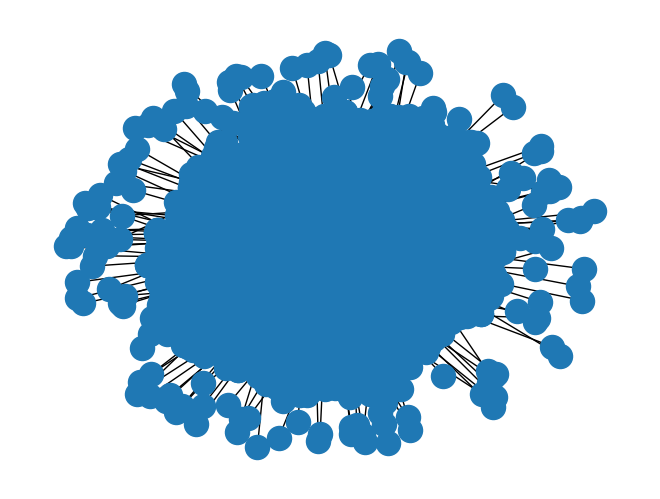

In [136]:
nx.draw(G)

In [127]:
!pip install node2vec

In [128]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=20, walk_length=16, num_walks=10)

model = node2vec.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/10157 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


In [143]:
{i:model.wv[i] for i in df['AI Tool Name']}

{' Farm3D': array([-0.23143277, -0.33916494,  0.23043294,  0.29173073,  0.487899  ,
         0.01801928, -0.13039067,  0.4343623 , -0.99932224,  0.22907494,
        -0.04600458, -0.27366883, -0.11234019,  0.95926225,  0.910656  ,
         0.28534696,  0.11987132, -1.4126147 ,  0.11062099,  0.46794137],
       dtype=float32),
 ' Mailbutler Ai': array([ 0.29740712, -0.5944103 , -0.26545718,  0.84782135, -0.13548493,
        -0.7520207 ,  0.28122208,  0.60909194, -0.858587  ,  0.6062014 ,
        -0.61732095, -0.15743293,  0.10691317,  0.16644327, -0.17180158,
         0.8001859 ,  0.44143277, -0.2991163 , -0.31241724, -0.3679516 ],
       dtype=float32),
 ' Maverick ': array([-0.33952552,  0.6109256 , -0.71086484,  0.06928143, -0.02967128,
         0.48513526,  0.35546586,  0.7317854 , -1.1479975 ,  0.5109652 ,
        -0.05464102, -0.07979228, -0.53717285, -0.37684414,  0.24565002,
         1.7670685 ,  0.15945673,  0.17397788,  0.13884787, -0.5432939 ],
       dtype=float32),
 '0Xai': 

In [159]:
print('Рекомендация похожих приложений с Open Ai Chatgpt')
print('-'*40)
for node, _ in model.wv.most_similar('Open Ai Chatgpt',topn=12):
  if node in list(df['AI Tool Name']):
    print((node, _))

Рекомендация похожих приложений с Open Ai Chatgpt
----------------------------------------
('Ai Lawyer', 0.914279580116272)
('Intellibar', 0.9023630619049072)
('Webcopilot.Ai', 0.9002156257629395)
('Booltool', 0.8929806351661682)
('5-Out', 0.8724900484085083)


In [139]:
print('Рекомендация похожих приложений с Ai Studio ')
print('-'*40)
for node, _ in model.wv.most_similar('Ai Studio',topn=12):
  if node in list(df['AI Tool Name']):
    print((node, _))

Рекомендация похожих приложений с Ai Studio 
----------------------------------------
('Film Face', 0.8768125772476196)
('Wondershare Virtulook', 0.8480267524719238)
('Infinit Backgrounds', 0.8271988034248352)
('Watchthis.Dev', 0.7997674942016602)
('Restogpt', 0.7879500985145569)


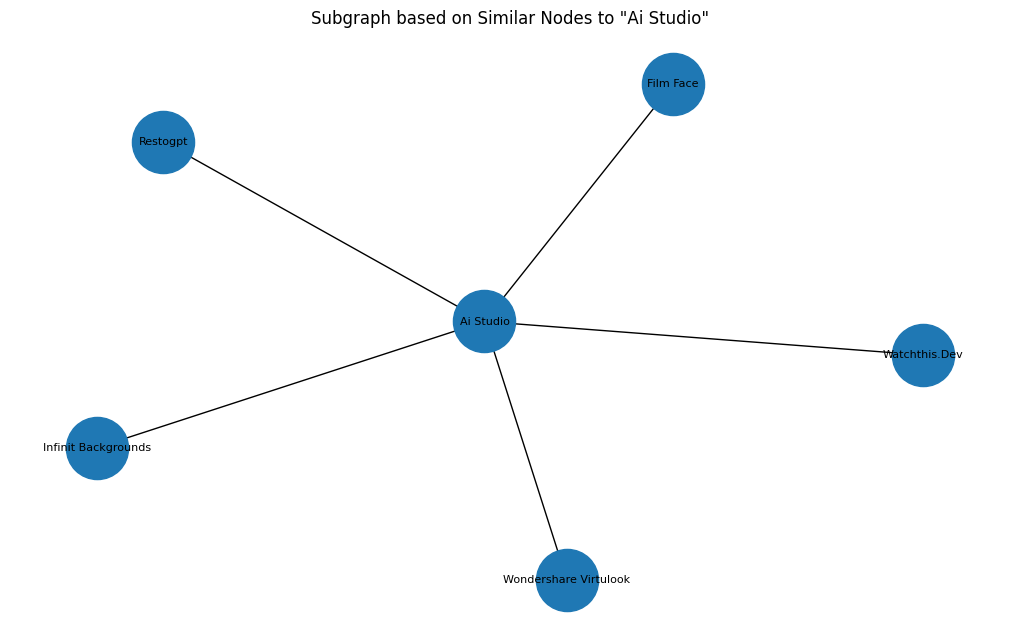

In [144]:
G = nx.Graph()

# Добавляем узлы и ребра на основе запроса
for node, _ in model.wv.most_similar('Ai Studio', topn=12):
    if node in list(df['AI Tool Name']):
        G.add_node(node)
        G.add_edge('Ai Studio', node)

# Рисуем подграф
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=8)
plt.title('Subgraph based on Similar Nodes to "Ai Studio"')
plt.show()


In [149]:
G = nx.Graph(label="AI Tool Name")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['AI Tool Name'],label="ai_tool")
    G.add_node(rowi['cluster'],label="CLUSTER")
    G.add_edge(rowi['AI Tool Name'], rowi['cluster'], label="titles to cluster")
    G.add_node(rowi['Major Category'],label="category")
    G.add_edge(rowi['AI Tool Name'], rowi['Major Category'], label="is in category")
    G.add_node(rowi['Free/Paid/Other'],label="pay")
    G.add_edge(rowi['AI Tool Name'], rowi['Free/Paid/Other'], label="costs")

    indices = find_similar(tfidf, i, top_n = 5)
    snode="*"+rowi['AI Tool Name'][:15].strip()+"*"
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['AI Tool Name'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['AI Tool Name'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))

 iter 0 -- 0.005441904067993164 seconds --
 iter 1000 -- 5.042644023895264 seconds --
 iter 2000 -- 9.766770839691162 seconds --
 iter 3000 -- 12.438121557235718 seconds --
 iter 4000 -- 14.593778610229492 seconds --
 finish -- 19.132222890853882 seconds --


In [150]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="ai_tool":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key)
        weight.append(w)

    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)
    return result;

In [151]:
result = get_recommendation("Open Ai Chatgpt")
print("-"*40+"\n Recommendation for 'Open Ai Chatgpt'\n"+"-"*40)
print(result.head())


----------------------------------------
 Recommendation for 'Open Ai Chatgpt'
----------------------------------------
Ai Lawyer        0.830901
Cognosys         0.830901
Intellibar       0.699120
Booltool         0.697820
Webcopilot.Ai    0.689892
dtype: float64


In [153]:
result = get_recommendation("Ai Studio")
print("-"*40+"\n Recommendation for 'Ai Studio'\n"+"-"*40)
print(result.head())

----------------------------------------
 Recommendation for 'Ai Studio'
----------------------------------------
Film Face                1.267584
Wondershare Virtulook    1.267584
Infinit Backgrounds      1.116221
Baked Ai                 0.709473
Productshots             0.709473
dtype: float64


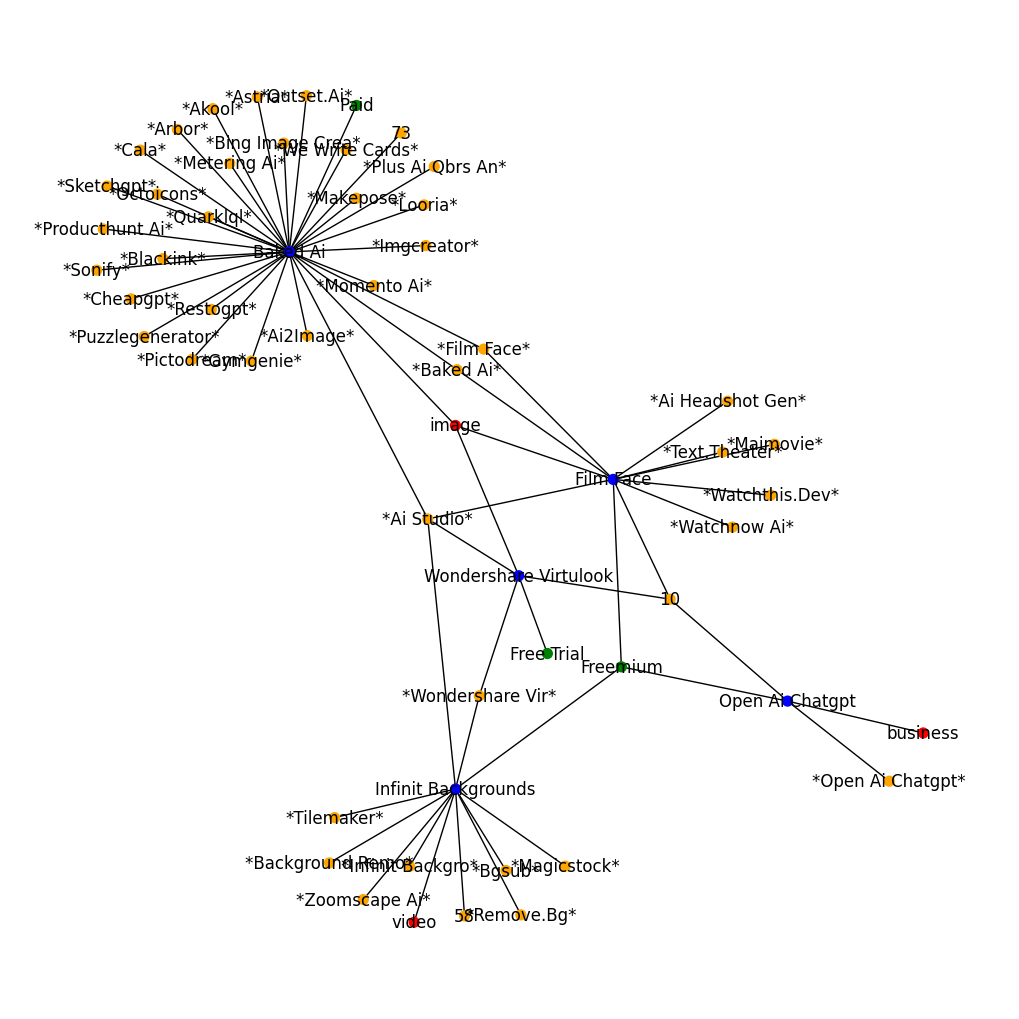

In [154]:
reco=list(result.index[:4].values)
reco.extend(["Open Ai Chatgpt"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)